# SMA Crossover Strategy Project Guideline

## Project Overview
This project implements and backtests a Simple Moving Average (SMA) Crossover trading strategy using Python and the Backtrader library. The strategy is optimized using grid search to find the best parameters.

## Table of Contents
1. [Install the necessary libraries & Ignore warnings](#1-install-the-necessary-libraries--ignore-warnings)
2. [SMA crossover strategy class](#2-sma-crossover-strategy-class)
3. [Define Backtest Engine class](#3-define-backtest-engine-class)
4. [Backtest the strategy (find the best parameters by GridSearch)](#4-backtest-the-strategy-find-the-best-parameters-by-gridsearch)

## Detailed Sections

### 1. Install the necessary libraries & Ignore warnings
- Import required modules (warnings, backtrader, yfinance, pandas, numpy, matplotlib, seaborn, tabulate)
- Configure warnings to be ignored
- Install necessary libraries using pip (if needed)

### 2. SMA crossover strategy class
- Define the `SMACrossStrategy` class, which inherits from `bt.Strategy`
- Implement strategy logic:
  - Set up parameters for short/long windows and trade size
  - Calculate short and long SMAs
  - Generate buy/sell signals based on SMA crossovers
  - Manage position sizing and trade execution
  - Track trades, equity, and drawdown
- Implement methods for:
  - Calculating trade size
  - Handling trade notifications

### 3. Define Backtest Engine class
- Create the `BacktestingEngine` class
- Implement methods for:
  - Downloading and processing historical data
  - Running backtests
  - Analyzing results (including performance metrics like Sharpe ratio, returns, volatility)
  - Plotting results
  - Optimizing strategy parameters
  - Displaying optimization results (including heatmaps and 3D surface plots)

### 4. Backtest the strategy (find the best parameters by GridSearch)
- Set up the main execution block
- Create an instance of the BacktestingEngine
- Define parameter ranges for optimization:
  - Short MA range
  - Long MA range
  - Trade size range
- Run the optimization process using grid search
- Display the best parameters and corresponding performance metrics
- Plot the results using the optimal parameters
- Visualize the optimization results using heatmaps and 3D surface plots

## Next Steps
- Test the strategy on different assets and timeframes
- Implement additional technical indicators or entry/exit conditions
- Explore more sophisticated optimization techniques (e.g., genetic algorithms)
- Incorporate advanced risk management features
- Consider real-world factors like slippage and more realistic commission structures
- Implement walk-forward optimization or out-of-sample testing

By following this guideline, you'll create a comprehensive SMA Crossover Strategy project that covers strategy development, backtesting, optimization, and analysis, aligned with the structure of your existing code.

# 1. Install the neccecary libraries & Ignore warnings

In [6]:
# ignore warnings
import warnings

warnings.filterwarnings("ignore")

# Install necessary libraries directly within a Jupyter Notebook
!pip install backtrader yfinance pandas matplotlib


[notice] A new release of pip is available: 24.0 -> 24.1.1
[notice] To update, run: pip install --upgrade pip


# 2. SMA crossover strategy class

In [7]:
import backtrader as bt
import yfinance as yf
import pandas as pd
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
from itertools import product
from tabulate import tabulate
import seaborn as sns

class SMACrossStrategy(bt.Strategy):
    """
    A Simple Moving Average (SMA) Crossover Strategy.
    This strategy generates buy signals when the short-term SMA crosses above the long-term SMA,
    and sell signals when the short-term SMA crosses below the long-term SMA.
    """

    # Default parameters for the strategy
    params = (
        ('short_window', 5),   # Period for the short-term SMA
        ('long_window', 20),   # Period for the long-term SMA
        ('trade_size', 0.01),  # Size of each trade as a fraction of the total portfolio value
    )

    def __init__(self):
        """
        Initialize the strategy, setting up indicators and data structures for tracking performance.
        """
        # Calculate and store the short-term and long-term Simple Moving Averages
        self.short_ma = bt.indicators.SimpleMovingAverage(
            self.data.close, period=self.params.short_window)
        self.long_ma = bt.indicators.SimpleMovingAverage(
            self.data.close, period=self.params.long_window)
        
        # Create a CrossOver indicator to generate trading signals
        self.crossover = bt.indicators.CrossOver(self.short_ma, self.long_ma)
        
        # Lists to store trade information and performance metrics
        self.trades = []         # List of all completed trades
        self.trade_returns = []  # Returns of each trade
        self.buys = []           # Dates of buy signals
        self.sells = []          # Dates of sell signals

        # Tracking equity and drawdown
        self.equity = []         # Daily equity values
        self.max_drawdown = 0    # Maximum drawdown experienced
        self.peak_equity = 0     # Highest equity value reached

    def next(self):
        """
        Core strategy logic, called for each bar in the data feed.
        Generates and executes trading signals based on SMA crossovers.
        """
        # Buy signal: short-term SMA crosses above long-term SMA
        if self.crossover > 0:
            if self.position.size < 0:  # If we're currently short, close the position
                self.close()
            self.buy(size=self.calculate_trade_size())  # Open a long position
            self.buys.append(self.data.datetime.date(0))  # Record the buy date
        
        # Sell signal: short-term SMA crosses below long-term SMA
        elif self.crossover < 0:
            if self.position.size > 0:  # If we're currently long, close the position
                self.close()
            self.sell(size=self.calculate_trade_size())  # Open a short position
            self.sells.append(self.data.datetime.date(0))  # Record the sell date

        # Update equity and drawdown calculations
        current_equity = self.broker.getvalue()
        self.equity.append(current_equity)
        self.peak_equity = max(self.peak_equity, current_equity)
        drawdown = (self.peak_equity - current_equity) / self.peak_equity
        self.max_drawdown = max(self.max_drawdown, drawdown)

    def calculate_trade_size(self):
        """
        Calculate the size of the trade based on the specified trade_size parameter.
        
        :return: Number of units to trade
        """
        trade_cash = self.broker.getvalue() * self.params.trade_size
        return self.broker.getposition(self.data).size or int(trade_cash / self.data.close[0])

    def notify_trade(self, trade):
        """
        Called when a trade is completed. Used to log trade information and calculate returns.
        
        :param trade: The completed trade object
        """
        if trade.isclosed:
            self.trades.append(trade)
            returns = trade.pnlcomm / trade.price  # Calculate the return of this trade
            self.trade_returns.append(returns)

# 3. Define Backtest Engine class 

In [8]:
class BacktestingEngine:
    def __init__(self, ticker, start_date, end_date, initial_cash=100000.0, commission=0.001):
        """
        Initialize the BacktestingEngine with given parameters.
        
        :param ticker: Stock symbol to backtest
        :param start_date: Start date for historical data
        :param end_date: End date for historical data
        :param initial_cash: Initial capital for backtesting
        :param commission: Commission rate for trades
        """
        self.ticker = ticker
        self.start_date = start_date
        self.end_date = end_date
        self.initial_cash = initial_cash
        self.commission = commission
        self.data = self.download_data()
        self.results = None

    def download_data(self):
        """
        Download historical price data for the specified ticker and date range.
        
        :return: DataFrame containing historical price data, or None if download fails
        """
        try:
            data = yf.download(self.ticker, start=self.start_date, end=self.end_date)
            if data.empty:
                raise ValueError("No data available for the specified date range")
            return data
        except Exception as e:
            print(f"Error downloading data: {e}")
            return None

    def run_backtest(self, short_window, long_window, trade_size):
        """
        Run a backtest with the specified parameters.
        
        :param short_window: Short-term SMA window
        :param long_window: Long-term SMA window
        :param trade_size: Size of each trade as a fraction of portfolio value
        :return: Results of the backtest, or None if backtest fails
        """
        if self.data is None:
            print("No data available for backtesting")
            return None

        cerebro = bt.Cerebro()
        cerebro.broker.setcash(self.initial_cash)
        cerebro.broker.setcommission(commission=self.commission)
        cerebro.addstrategy(SMACrossStrategy, short_window=int(short_window), long_window=int(long_window), trade_size=trade_size)
        cerebro.adddata(bt.feeds.PandasData(dataname=self.data))
        cerebro.addanalyzer(bt.analyzers.DrawDown, _name="drawdown")
        cerebro.addanalyzer(bt.analyzers.Returns, _name="returns")

        self.results = cerebro.run()
        return self.results[0]

    def analyze_results(self, strategy, print_details=True, print_annual_metrics=True, print_trades_table=False):
        """
        Analyze the results of a backtest.
        
        :param strategy: The strategy object containing backtest results
        :param print_details: Whether to print detailed analysis
        :param print_annual_metrics: Whether to print annualized metrics
        :param print_trades_table: Whether to print a table of all trades
        :return: Dictionary containing key performance metrics
        """
        if strategy is None:
            print("No strategy results to analyze")
            return None

        # Calculate performance metrics
        max_drawdown = strategy.max_drawdown
        total_return = strategy.broker.getvalue() / self.initial_cash - 1
        total_return_cash = strategy.broker.getvalue() - self.initial_cash
        trade_returns = np.array(strategy.trade_returns)
        annual_metrics = self.calculate_annualized_metrics(strategy)
        
        # Print detailed analysis if requested
        if print_details:
            print("\n" + "="*50)
            print(f"Backtest Results for {self.ticker}:")
            print(f"\nDetailed Analysis:")
            print(f"Initial cash: {self.initial_cash}")
            print(f"Final cash: {strategy.broker.getvalue()}")
            print(f"Total return (cash): {total_return_cash:.2f}")
            print(f"Total return (%): {total_return:.2%}")
            print(f"Max drawdown: {max_drawdown:.2%}")
            print(f"Number of trades: {len(strategy.trades)}")

        # Print annualized metrics if requested
        if print_annual_metrics:
            print("\n" + "="*50)
            print("\nAnnualized Metrics:")
            print(f"Annual return: {annual_metrics['Annual Return']:.2%}")
            print(f"Annual volatility: {annual_metrics['Annual Volatility']:.2%}")
            print(f"Sharpe ratio: {annual_metrics['Sharpe Ratio']:.4f}")

        # Print trades table if requested
        if print_trades_table:
            trades = []
            for trade in strategy.trades:
                trades.append([trade.ref, trade.dtopen, trade.dtclose, trade.pnl, trade.pnlcomm])
            trades_df = pd.DataFrame(trades, columns=['Trade ID', 'Open Date', 'Close Date', 'Profit/Loss', 'PnL (incl. commission)'])
            print("\n" + "="*50)
            print("\nTrades:")
            print(tabulate(trades_df, headers='keys', tablefmt='psql'))
        
        # Return key performance metrics
        return {
            'sharpe_ratio': annual_metrics['Sharpe Ratio'],
            'annual_return': annual_metrics['Annual Return'],
            'annual_volatility': annual_metrics['Annual Volatility'],          
            'max_drawdown': max_drawdown,
            'total_return': total_return
        }

    def plot_results(self, short_window, long_window, trade_size):
        """
        Plot the results of a backtest.
        
        :param short_window: Short-term SMA window
        :param long_window: Long-term SMA window
        :param trade_size: Size of each trade as a fraction of portfolio value
        """
        if self.data is None:
            print("No data available for plotting")
            return

        strategy = self.run_backtest(short_window, long_window, trade_size)
        if strategy is None:
            return

        # Create the plot
        fig, ax = plt.subplots(figsize=(15, 8))
        
        # Plot price and SMA lines
        ax.plot(self.data.index, self.data['Close'], label='Close Price', alpha=0.7)
        ax.plot(self.data.index, self.data['Close'].rolling(window=short_window).mean(), label=f'{short_window}-day SMA', alpha=0.7)
        ax.plot(self.data.index, self.data['Close'].rolling(window=long_window).mean(), label=f'{long_window}-day SMA', alpha=0.7)
        
        # Plot buy and sell signals
        ax.scatter(strategy.buys, self.data.loc[strategy.buys]['Close'], marker='^', color='g', label='Buy Signal', alpha=1, s=200)
        ax.scatter(strategy.sells, self.data.loc[strategy.sells]['Close'], marker='v', color='r', label='Sell Signal', alpha=1, s=200)

        # Add vertical lines for buy and sell signals
        for buy_date in strategy.buys:
            ax.axvline(x=buy_date, color='g', linestyle='--', alpha=0.5)
        for sell_date in strategy.sells:
            ax.axvline(x=sell_date, color='r', linestyle='--', alpha=0.5)
        
        # Set plot title and labels
        ax.set_title(f'SMA Crossover Strategy: {self.ticker}\n{self.start_date} to {self.end_date}')
        ax.set_xlabel('Date')
        ax.set_ylabel('Price')
        ax.legend()
        ax.grid(True, alpha=0.3)
        
        plt.xticks(rotation=45)
        
        # Add performance metrics to the plot
        analysis = self.analyze_results(strategy)
        performance_text = (
            f"Sharpe Ratio: {analysis['sharpe_ratio']:.4f}\n"
            f"Annual Return: {analysis['annual_return']:.2%}\n"
            f"Annual Volatility: {analysis['annual_volatility']:.2%}\n"
            f"Max Drawdown: {analysis['max_drawdown']:.2%}\n"
            f"Total Return: {analysis['total_return']:.2%}"
        )
        plt.text(0.05, 0.95, performance_text, transform=ax.transAxes, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))
        plt.tight_layout()
        plt.show()

    def calculate_annualized_metrics(self, strategy, risk_free_rate=0.00):
        """
        Calculate annualized performance metrics.
        
        :param strategy: The strategy object containing backtest results
        :param risk_free_rate: The risk-free rate for Sharpe ratio calculation
        :return: Dictionary containing annualized metrics
        """
        # Calculate the number of years
        first_date = self.data.index[0].to_pydatetime().date()
        last_date = self.data.index[-1].to_pydatetime().date()
        total_days = (last_date - first_date).days
        annual_factor = 252 / total_days

        # Calculate daily returns
        daily_returns = pd.Series(strategy.equity).pct_change().dropna()

        if len(daily_returns) > 0:
            # Calculate total return and annualize it
            total_return = (strategy.broker.getvalue() / self.initial_cash) - 1
            annual_return = (1 + total_return) ** annual_factor - 1

            # Calculate annualized volatility
            annual_volatility = daily_returns.std() * np.sqrt(252)

            # Calculate Sharpe ratio
            if annual_volatility != 0:
                sharpe_ratio = (annual_return - risk_free_rate) / annual_volatility
            else:
                sharpe_ratio = 0
        else:
            annual_return = annual_volatility = sharpe_ratio = 0

        return {
            "Annual Return": annual_return,
            "Annual Volatility": annual_volatility,
            "Sharpe Ratio": sharpe_ratio,
        }

    def optimize_parameters(self, short_window_range, long_window_range, trade_size_range):
        """
        Optimize strategy parameters using grid search.
        
        :param short_window_range: Range of short-term SMA windows to test
        :param long_window_range: Range of long-term SMA windows to test
        :param trade_size_range: Range of trade sizes to test
        :return: DataFrame containing results of all parameter combinations
        """
        results = []
        for short, long, size in product(short_window_range, long_window_range, trade_size_range):
            if short >= long:
                continue
            strategy = self.run_backtest(short, long, size)
            if strategy is None:
                continue
            analysis = self.analyze_results(strategy, print_details=False, print_annual_metrics=False, print_trades_table=False)
            if analysis is None:
                continue
            results.append({
                'short_window': short,
                'long_window': long,
                'trade_size': size,
                'total_trades': (int)(len(strategy.trades)),
                'sharpe_ratio': analysis['sharpe_ratio'],
                'total_return': analysis['total_return'],
                'max_drawdown': analysis['max_drawdown'],
                'annual_return': analysis['annual_return'],
                'annual_volatility': analysis['annual_volatility']
            })
            print(f"Processed: Short={short}, Long={long}, Trade Size={size:.2%}, Sharpe={analysis['sharpe_ratio']:.4f}, Total Return={analysis['total_return']:.2%}")
        
        results_df = pd.DataFrame(results)
        results_df = results_df.sort_values('sharpe_ratio', ascending=False).reset_index(drop=True)
        
        return results_df

    def display_optimization_results(self, results_df, top_n=10):
        """
        Display the results of parameter optimization.
        
        :param results_df: DataFrame containing optimization results
        :param top_n: Number of top results to display
        """
        print(f"\nTop {top_n} Optimization Results:")
        print(tabulate(results_df.head(top_n), headers='keys', tablefmt='psql', floatfmt=".4f"))
        
        # Create heatmap of Sharpe ratios
        pivot_df = results_df.groupby(['short_window', 'long_window'])['sharpe_ratio'].mean().unstack()
        
        plt.figure(figsize=(12, 8))
        sns.heatmap(pivot_df, annot=True, cmap='YlGnBu', fmt='.2f')
        plt.title('Sharpe Ratio Heatmap')
        plt.xlabel('Long Window')
        plt.ylabel('Short Window')
        plt.show()

        # Create 3D surface plot of Sharpe ratios
        fig = plt.figure(figsize=(12, 8))
        ax = fig.add_subplot(111, projection='3d')
        X, Y = np.meshgrid(pivot_df.columns, pivot_df.index)
        surf = ax.plot_surface(X, Y, pivot_df.values, cmap='viridis')
        ax.set_xlabel('Long Window')
        ax.set_ylabel('Short Window')
        ax.set_zlabel('Sharpe Ratio')
        ax.set_title('3D Surface Plot of Sharpe Ratio')
        fig.colorbar(surf, shrink=0.5, aspect=5)
        plt.show()

# 4. Backtest the strategy ( find the best parameters by GridSearch )

[*********************100%%**********************]  1 of 1 completed


Processed: Short=5, Long=10, Trade Size=5.00%, Sharpe=0.2581, Total Return=31.34%
Processed: Short=5, Long=10, Trade Size=10.00%, Sharpe=0.2674, Total Return=62.69%
Processed: Short=5, Long=10, Trade Size=15.00%, Sharpe=0.2630, Total Return=65.28%
Processed: Short=5, Long=20, Trade Size=5.00%, Sharpe=0.3438, Total Return=42.19%
Processed: Short=5, Long=20, Trade Size=10.00%, Sharpe=0.3495, Total Return=84.52%
Processed: Short=5, Long=20, Trade Size=15.00%, Sharpe=0.3520, Total Return=126.85%
Processed: Short=5, Long=30, Trade Size=5.00%, Sharpe=0.3223, Total Return=38.91%
Processed: Short=5, Long=30, Trade Size=10.00%, Sharpe=0.3362, Total Return=77.95%
Processed: Short=5, Long=30, Trade Size=15.00%, Sharpe=0.3445, Total Return=116.99%
Processed: Short=5, Long=40, Trade Size=5.00%, Sharpe=0.1956, Total Return=24.07%
Processed: Short=5, Long=40, Trade Size=10.00%, Sharpe=0.2031, Total Return=48.15%
Processed: Short=5, Long=40, Trade Size=15.00%, Sharpe=0.2214, Total Return=58.31%
Proces

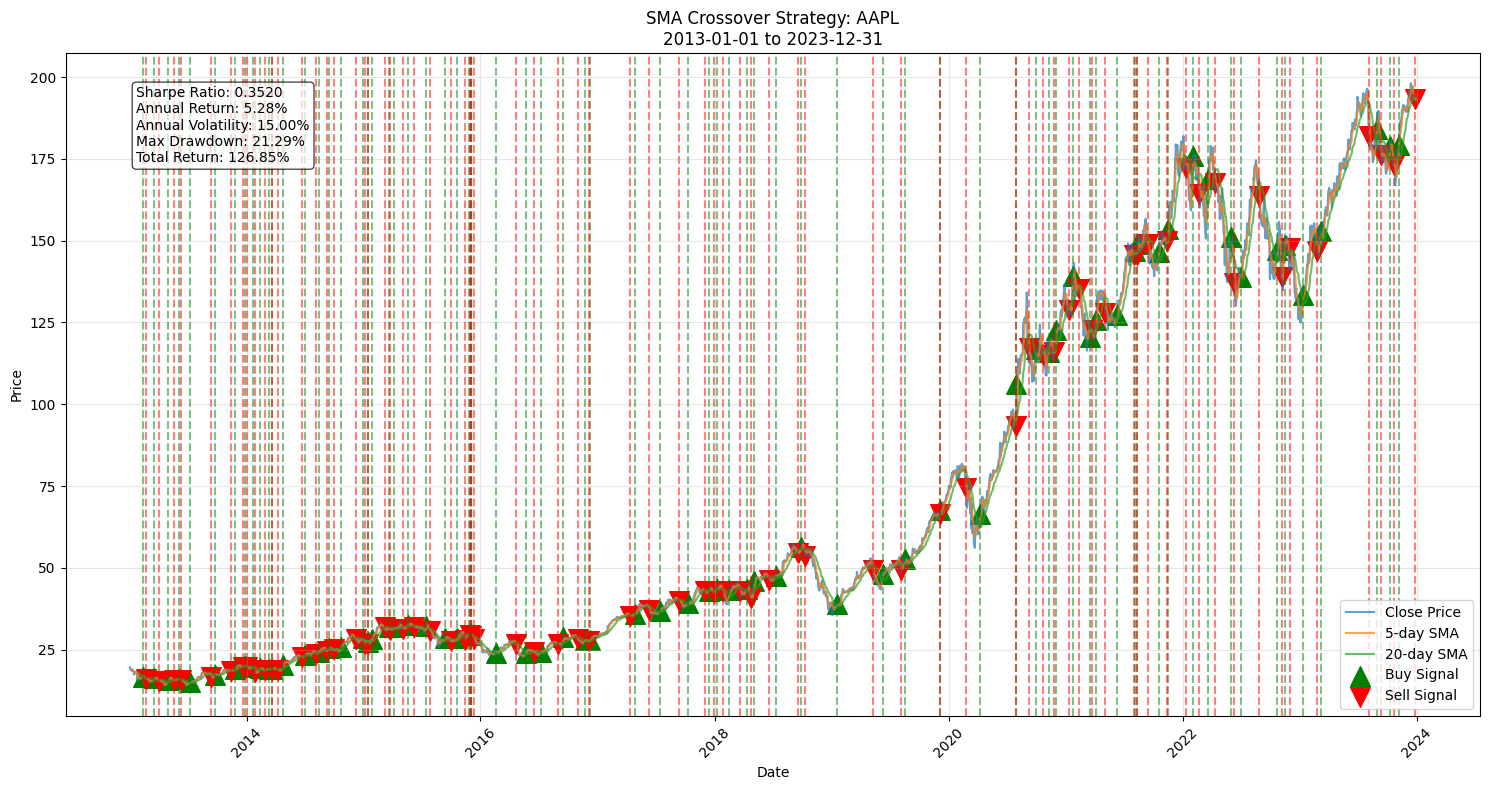


Top 10 Optimization Results:
+----+----------------+---------------+--------------+----------------+----------------+----------------+----------------+-----------------+---------------------+
|    |   short_window |   long_window |   trade_size |   total_trades |   sharpe_ratio |   total_return |   max_drawdown |   annual_return |   annual_volatility |
|----+----------------+---------------+--------------+----------------+----------------+----------------+----------------+-----------------+---------------------|
|  0 |         5.0000 |       20.0000 |       0.1500 |       145.0000 |         0.3520 |         1.2685 |         0.2129 |          0.0528 |              0.1500 |
|  1 |         5.0000 |       20.0000 |       0.1000 |       145.0000 |         0.3495 |         0.8452 |         0.1640 |          0.0392 |              0.1122 |
|  2 |         5.0000 |       30.0000 |       0.1500 |       114.0000 |         0.3445 |         1.1699 |         0.2712 |          0.0499 |              0

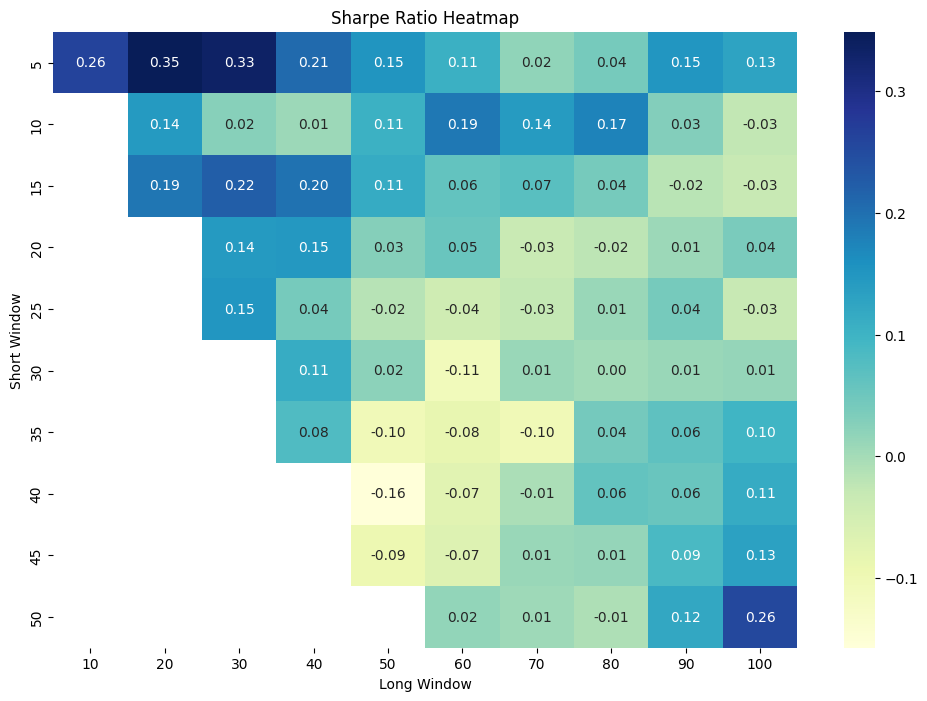

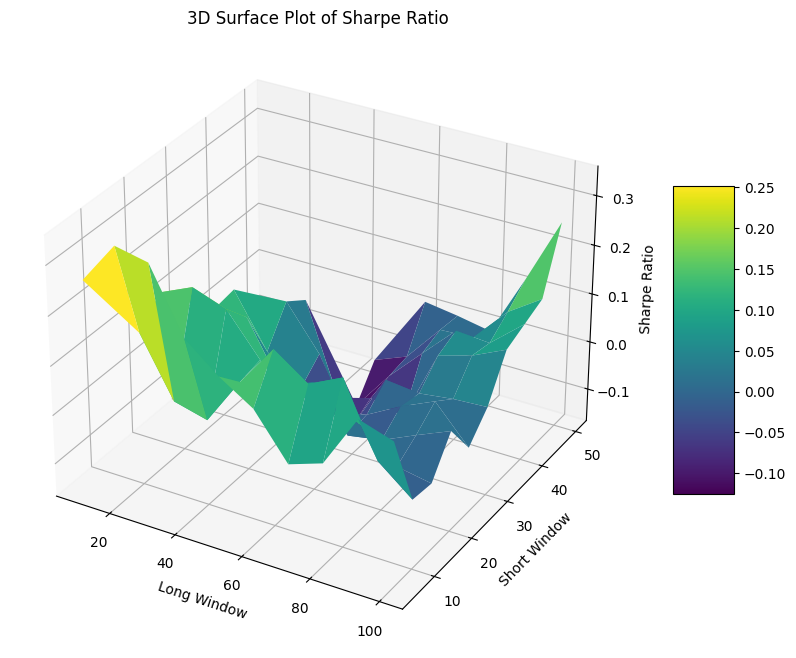

In [9]:

if __name__ == "__main__":
    engine = BacktestingEngine('AAPL', '2013-01-01', '2023-12-31')
    
    # Optimize parameters using grid search
    short_ma_range = range(5, 51, 5)
    long_ma_range = range(10, 101, 10)
    trade_size_range = [0.05, 0.1, 0.15]
    optimized_results = engine.optimize_parameters(short_ma_range, long_ma_range, trade_size_range)
    
    # Print best parameters and plot results 
    if not optimized_results.empty:
        best_params = optimized_results.iloc[0]
        print(f"\nBest parameters:")
        print(f"Short window: {best_params['short_window']}")
        print(f"Long window: {best_params['long_window']}")
        print(f"Trade size: {best_params['trade_size']:.2%}")
        print(f"Sharpe ratio: {best_params['sharpe_ratio']:.4f}")
        print(f"Total trades: {best_params['total_trades']}")
        print(f"Total return: {best_params['total_return']:.2%}")
        
        # Plot results with best parameters
        engine.plot_results(int(best_params['short_window']), int(best_params['long_window']), best_params['trade_size'])

        # Display optimization results
        engine.display_optimization_results(optimized_results)
    else:
        print("Optimization failed to produce valid results.")